# Initial Test Data Analysis
See [This GitLAB Issue](https://code.crearecomputing.com/hearingproducts/open-hearing-group/open-hearing-hardware/-/issues/1) for details ont he data collection. 

In this notebook:

0. Load Common Data Structure (Setup)
1. Speaker calibration
2. Mic amplitude calibrations
3. Mic phase calibrations

# 0. Load Common Data Structures

In [1]:
%matplotlib inline

## Imports

In [2]:
# Import dependencies
import os
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, ndimage, optimize, interpolate

from auren.core import io
from auren.core import signal_processing_utils as spu
from auren.core.model import StraightTube
from auren.core.units import units

## Helper utillity functions

In [3]:
def get_meta_value_units(section, *keys):
    """ REquires test_meta and units to be global variables"""
    section = test_meta[section]
    root = section
    for key in keys:
        root = root.get(key)
    return root["value"] * units(root["units"])

def get_ptheory(f, x, model, **kwargs):
    for k, v in kwargs.items():
        setattr(model, k, v)
    return model.p(f, x)

def todB(a):
    return 20 * np.log10(np.abs(a) / 20e-6)

## File Paths and Metadata Loading

In [4]:
# Figure style and line style
figkwargs = dict(figsize=(6.5, 6.5 / 1.618034), dpi=200)
linekwargs = dict(lw=1, alpha=0.5)

# Set up path to the data
path = os.path.join("Olympus", "Projects", "1010564-OPEN-HEARING", "Technical Work", "Testing", "Data", "2024-03-25_OWAI-Calibration-Data-Collection")  # From windows
if os.environ.get("OLYMPUS_PROJECTS_PATH", False):
    path = path.replace(os.path.join('Olympus', "Projects"), os.environ.get("OLYMPUS_PROJECTS_PATH"))
print("Looking for data in this path:", path)

path_meta = os.path.join(path, 'testdata.yaml')
print("Looking for test meta data in this path:", path_meta)

# Load test metadata
test_meta = io.load_test_data(path_meta)
# pprint(test_meta)

# Set constants
speed_of_sound = 343 * units.m / units.s
n_channels = 4

# probe geometry
length_probe = get_meta_value_units("probe_geometry", "length")
length_tests = [length_probe + get_meta_value_units("test_geometry", "cavern_" + str(i + 1), "length") for i in range(4)]
x_probe = [
    length_probe + get_meta_value_units("test_geometry", "cavern_" + str(i + 1), "x_of_probe")
    for i in range(4)
    ]
x_mic = get_meta_value_units('probe_geometry', 'mic_positions')

# Dictionary to hold the calibration data
calibration_data = {"RL": 0.999, "R0": 0.999}  # We will store the calibration data here

Looking for data in this path: /mnt/o/1010564-OPEN-HEARING/Technical Work/Testing/Data/2024-03-25_OWAI-Calibration-Data-Collection
Looking for test meta data in this path: /mnt/o/1010564-OPEN-HEARING/Technical Work/Testing/Data/2024-03-25_OWAI-Calibration-Data-Collection/testdata.yaml


## Data loading

In [5]:
test_keys = [
    'cavern_1_B&K_in_probe_port',
    'cavern_2_B&K_in_probe_port',
    'cavern_3_B&K_in_probe_port',
    'cavern_4_B&K_in_probe_port',
    'cavern_1_probe_port_sealed',
    'cavern_2_probe_port_sealed',
    'cavern_3_probe_port_sealed',
    'cavern_4_probe_port_sealed',
    ]

# make sure all the data has the same shape
fn = os.path.join(path, test_meta["test_metadata"][test_keys[0]]["files"][0][0])
_, _, samplerate = io.load_wav(fn)
duration = test_meta["chirp_parameters"]["end_time"]["value"] - test_meta["chirp_parameters"]["start_time"]["value"]
data_slice = slice(
    int(test_meta["chirp_parameters"]["start_time"]["value"] * samplerate),
    int(test_meta["chirp_parameters"]["end_time"]["value"] * samplerate), None)

times = {}
data = {}
times_ref = {}
data_ref = {}
for i, test_key in enumerate(test_keys):
    cavern_times = []
    cavern_data = []
    cavern_times_ref = []
    cavern_data_ref = []
    for j, tests in enumerate(test_meta["test_metadata"][test_key]["files"]):
        fn = os.path.join(path, tests[0])
        t, d, samplerate = io.load_wav(fn, )
        cavern_times.append(t[data_slice])
        cavern_data.append(d[data_slice].T)
        if len(tests) == 1:
            continue
        fn = os.path.join(path, tests[1])
        t, d, samplerate_bk = io.load_wav(fn)
        slc = spu.trim_signal_sharp_jump(d, samplerate_bk, duration=5, kernel_size=65, end=True, return_index=True)
        cavern_times_ref.append(t[slc])
        cavern_data_ref.append(d[slc].T)
    times[test_key] = cavern_times
    data[test_key] = cavern_data
    times_ref[test_key] = cavern_times_ref
    data_ref[test_key] = cavern_data_ref
# Done reading all the data

Couldn't read file using scipy, falling back to soundfile. This was the error  WAV header is invalid: nAvgBytesPerSec must equal product of nSamplesPerSec and nBlockAlign, but file has nSamplesPerSec = 96000, nBlockAlign = 8, and nAvgBytesPerSec = 192000


Couldn't read file using scipy, falling back to soundfile. This was the error  WAV header is invalid: nAvgBytesPerSec must equal product of nSamplesPerSec and nBlockAlign, but file has nSamplesPerSec = 96000, nBlockAlign = 8, and nAvgBytesPerSec = 192000
Couldn't read file using scipy, falling back to soundfile. This was the error  WAV header is invalid: nAvgBytesPerSec must equal product of nSamplesPerSec and nBlockAlign, but file has nSamplesPerSec = 96000, nBlockAlign = 8, and nAvgBytesPerSec = 192000
Using scaling data from  /mnt/o/1010564-OPEN-HEARING/Technical Work/Testing/Data/2024-03-25_OWAI-Calibration-Data-Collection/BKProbe_001.dat
Couldn't read file using scipy, falling back to soundfile. This was the error  WAV header is invalid: nAvgBytesPerSec must equal product of nSamplesPerSec and nBlockAlign, but file has nSamplesPerSec = 96000, nBlockAlign = 8, and nAvgBytesPerSec = 192000
Using scaling data from  /mnt/o/1010564-OPEN-HEARING/Technical Work/Testing/Data/2024-03-25_OW

## Fourier Transforms and Data Wrangling

In [6]:
# Use last two tests
f_ref = []
p_ref = []
p = []
f = []
for key in test_keys:
    this_p_ref = []
    this_f_ref = []
    this_p = []
    this_f = []
    for test in [-2, -1]:
        my_f, my_p = spu.to_fourier(data[key][test], samplerate)
        keep_inds = (my_f >= 100) & (my_f < 20000)
        my_f = my_f[keep_inds]
        my_p = my_p[:, keep_inds]
        this_p.append(my_p)
        this_f.append(my_f)
        if not data_ref[key]:
            continue
        my_f_ref, my_p_ref = spu.to_fourier(data_ref[key][test], samplerate_bk)
        keep_inds = (my_f_ref >= 100) & (my_f_ref < 20000)
        my_f_ref = my_f_ref[keep_inds]
        my_p_ref = my_p_ref[keep_inds]
        this_p_ref.append(my_p_ref)
        this_f_ref.append(my_f_ref)

    this_p = np.stack(this_p, axis=0)
    this_f = np.stack(this_f, axis=0)
    p.append(this_p)
    f.append(this_f)
    if not this_p_ref:
        continue
    this_p_ref = np.stack(this_p_ref, axis=0)
    this_f_ref = np.stack(this_f_ref, axis=0)
    p_ref.append(this_p_ref)
    f_ref.append(this_f_ref)
p = np.stack(p, axis=0)
f = np.stack(f, axis=0)
p_ref = np.stack(p_ref, axis=0)
f_ref = np.stack(f_ref, axis=0)
axis_order = ['test_geometry', 'test_iteration', "channel", 'data']

In [7]:
R0 = calibration_data["R0"]
RL = calibration_data["RL"]
cavern_model = StraightTube(L=0, R0=R0, RL=RL, P0=1.0, PL=0.0)

# First, we need to try an align the theory with the measurements

In [8]:
20 * np.log10(np.abs(p_ref) / 20e-6).max()  # Scaling looks pretty good

55.2006885383478

### Plots

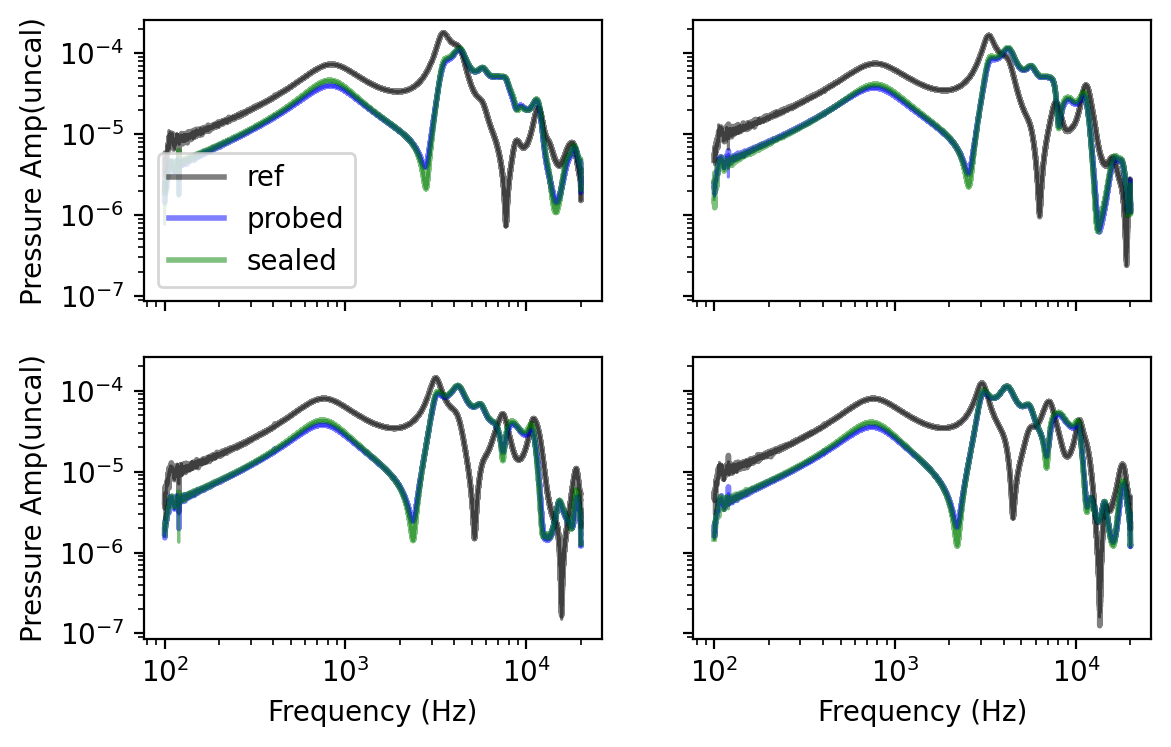

In [9]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, **figkwargs)
channel = 3
for i in range(2):
    for j in range(2):
        ii = i * 2 + j
        for jj in range(2):
            lw = 2-jj
            magdiff = np.abs(p[ii, jj, channel, :]).mean() / np.abs(p_ref[ii, jj, :]).mean()
            axs[i,j].loglog(f_ref[ii, jj], np.abs(p_ref[ii, jj, :]) * magdiff, 'k', label="ref", lw=lw, alpha=0.5)
            axs[i,j].loglog(f[ii, jj], np.abs(p[ii, jj, channel, :]), 'b', label="probed", lw=lw, alpha=0.5)
            axs[i,j].loglog(f[ii + 4, jj], np.abs(p[ii + 4, jj, channel, :]), 'g', label="sealed", lw=lw, alpha=0.5)
            if jj > 0 or i > 0 or j > 0:
                continue
            axs[i,j].legend()
axs[-1, 0].set_xlabel('Frequency (Hz)')
axs[-1, 1].set_xlabel('Frequency (Hz)')
axs[0, 0].set_ylabel('Pressure Amp(uncal)')
axs[-1, 0].set_ylabel('Pressure Amp(uncal)')
plt.show()

# 1. Speaker Calibration
Speaker was supposed to play a logarithmic chirp... what did it actually do?

## Peak Alignment

In [10]:
# Find peaks in the theoretical and reference pressure data
line_off_range = np.array([-3, 3]) * units.mm
ptrange = np.stack([
    np.stack([
        get_ptheory(f_ref[i] * units.Hz, x_probe[i] + lo, cavern_model, L=length_tests[i] + lo) for lo in line_off_range
        ], axis=1) for i in range(f_ref.shape[0])], axis=0)
# Only keep first 4 peaks so we can stack the results
theory_peaks = [
    [
        np.stack([signal.find_peaks(np.abs(ptrange[i, j, k]), prominence=8)[0][:4] for k in range(ptrange.shape[2])], axis=0)
    for j in range(ptrange.shape[1])]
for i in range(ptrange.shape[0])]
pref_peaks = [[signal.find_peaks(np.abs(p_ref[i, j]), width=128)[0] for j in range(p_ref.shape[1])] for i in range(p_ref.shape[0])]

/home/mpu/.pyenv/versions/3.11.2/envs/auren/lib/python3.11/site-packages/scipy/signal/_peak_finding.py:266: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  value = np.asarray(value, order='C', dtype=np.float64)


In [11]:
# Compute the offsets
loff = np.zeros(p_ref.shape[:2])
for tn in range(len(pref_peaks)):
    for ti in range(len(pref_peaks[tn])):
        in_between_limits = (pref_peaks[tn][ti][:, None] >= theory_peaks[tn][ti][1:]) & (pref_peaks[tn][ti][:, None] <= theory_peaks[tn][ti][:1])
        if not np.any(in_between_limits):
            continue
        inds = np.argwhere(in_between_limits)
        my_offsets = (pref_peaks[tn][ti][inds[:, 0]] - theory_peaks[tn][ti][1, inds[:, 1]]) \
            / (theory_peaks[tn][ti][0, inds[:, 1]] - theory_peaks[tn][ti][1, inds[:, 1]]) \
            * (line_off_range[-1] - line_off_range[0]) + line_off_range[0]
        loff[tn, ti] = my_offsets.mean().magnitude
length_offset_cavern = -loff.mean(axis=1) * units.mm
length_offset_cavern

Magnitude,[-0.1289427976706592 0.2061467786809117 -0.45608791716178476 -0.7673035040275675]
Units,millimeter


In [12]:
# Verify that what we did was good.
ptrange2 = np.stack([
        get_ptheory(f_ref[i] * units.Hz, x_probe[i] + length_offset_cavern[i], cavern_model, L=length_tests[i] + length_offset_cavern[i], alpha=0) for i in range(f_ref.shape[0])], axis=0)
# Only keep first 4 peaks so we can stack the results
theory_peaks2 = np.array([
        [signal.find_peaks(np.abs(ptrange2[i, j]), prominence=8)[0][:4]
    for j in range(ptrange2.shape[1])]
    for i in range(ptrange2.shape[0])])
# theory_peaks2, theory_peaks2.shape


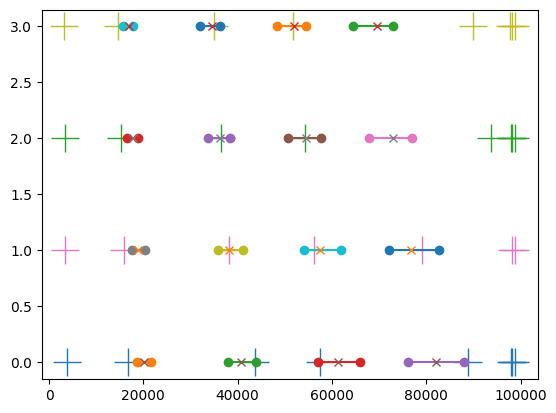

In [13]:

for i in range(4):
    plt.plot(pref_peaks[i][0], pref_peaks[i][0] * 0 + i, '+', ms=20)
    plt.plot(theory_peaks[i][0], theory_peaks[i][0] * 0 + i, 'o-')
    plt.plot(theory_peaks2[i][0], theory_peaks2[i][0] * 0 + i, 'x')


## Absorption Solution

In [14]:
def cost(x, cavern_model, l, xp, f, p_ref):
    amp, alpha = x
    p_theory = np.abs(get_ptheory(f, xp, cavern_model, L=l, absorption_loss=alpha) * amp)
    return np.linalg.norm(p_ref - p_theory)

res = np.zeros(p_ref.shape[:2], dtype=object)
for i in range(p_ref.shape[0]):
        for j in range(p_ref.shape[1]):
            resl = optimize.minimize(
                cost,
                [np.abs(p_ref[i]).mean(), 0.01],
                args=(
                    cavern_model,
                    length_tests[i] + length_offset_cavern[i],
                    x_probe[i] + length_offset_cavern[i],
                    f_ref[i, j] * units.Hz,
                    np.abs(p_ref[i, j])),
                    method="Nelder-Mead")
            res[i, j] = resl
            print((i,j), resl.x)


/home/mpu/.pyenv/versions/3.11.2/envs/auren/lib/python3.11/site-packages/scipy/optimize/_optimize.py:646: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  fx = np.asarray(fx).item()


(0, 0) [0.00124312 0.04785547]
(0, 1) [0.00124441 0.04790354]
(1, 0) [0.00113778 0.04202557]
(1, 1) [0.001135  0.0420235]
(2, 0) [0.00103437 0.03913431]
(2, 1) [0.00103283 0.03909384]
(3, 0) [0.00100181 0.03957316]
(3, 1) [0.00099871 0.03944342]


In [15]:
amp_alpha = np.array([[res[i, j].x for j in range(res.shape[1])] for i in range(res.shape[0])])
alpha = (amp_alpha[..., 1] / amp_alpha[..., 0]).mean() * amp_alpha[..., 0].mean()
amp = amp_alpha[..., 0].mean()

## Speaker Calibration

In [16]:
# Find the correction term compared to theory
p_theory = np.array([[get_ptheory(
    f_ref[i, j] * units.Hz,
    x_probe[i] + length_offset_cavern[i],
    cavern_model,
    L=length_tests[i] + length_offset_cavern[i],
    absorption_loss=alpha,
    P0=1)
    for j in range(f_ref.shape[1])]
    for i in range(f_ref.shape[0])])

speaker_p_correction = p_ref / p_theory

/tmp/ipykernel_13511/1760573262.py:2: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  p_theory = np.array([[get_ptheory(


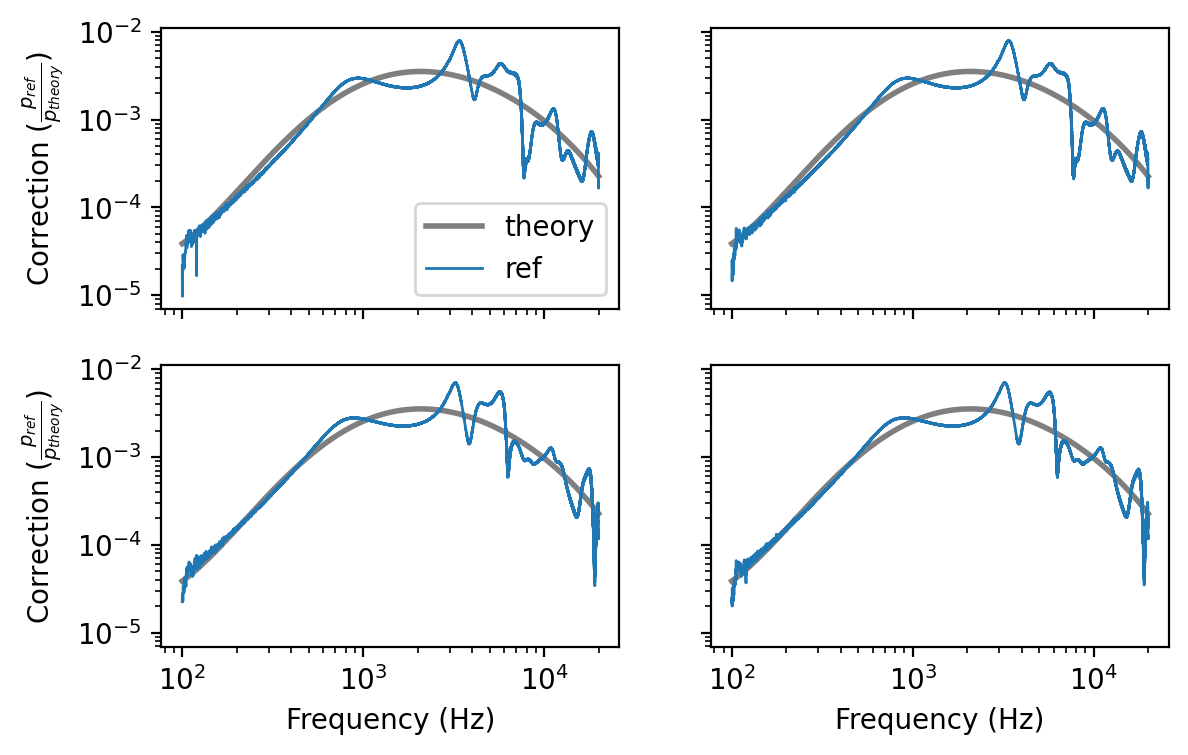

In [17]:
polydata = np.polyfit(np.log10(f_ref.ravel()), np.log10(np.abs(speaker_p_correction).ravel()), deg=5, w=1/f_ref.ravel())
calibration_data["speaker_amplitude"] = polydata
calibration_data["speaker_amplitude_f"] = lambda f, p: 10**np.polyval(p, np.log10(f))
calibration_data["length_offset_cavern"] = length_offset_cavern * units.mm
calibration_data["absorption"] = alpha

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, **figkwargs)
for i in range(2):
    for j in range(2):
        ii = i * 2 + j
        lw = 2
        speaker_cal = calibration_data["speaker_amplitude_f"](f_ref[i, j], calibration_data["speaker_amplitude"])
        axs[i,j].loglog(f_ref[i, j], np.abs(speaker_cal).T, 'k', label="theory", lw=lw, alpha=0.5)
        axs[i,j].loglog(f_ref[i, j], np.abs(speaker_p_correction[i, j, :]).T, 'C0', label="ref", lw=1, alpha=1)
        if i > 0 or j > 0:
            continue
        axs[i,j].legend()
axs[-1, 0].set_xlabel('Frequency (Hz)')
axs[-1, 1].set_xlabel('Frequency (Hz)')
axs[0, 0].set_ylabel(r'Correction ($\frac{p_{ref}}{p_{theory}}$)')
axs[-1, 0].set_ylabel(r'Correction ($\frac{p_{ref}}{p_{theory}}$)')
plt.show()

### Plots

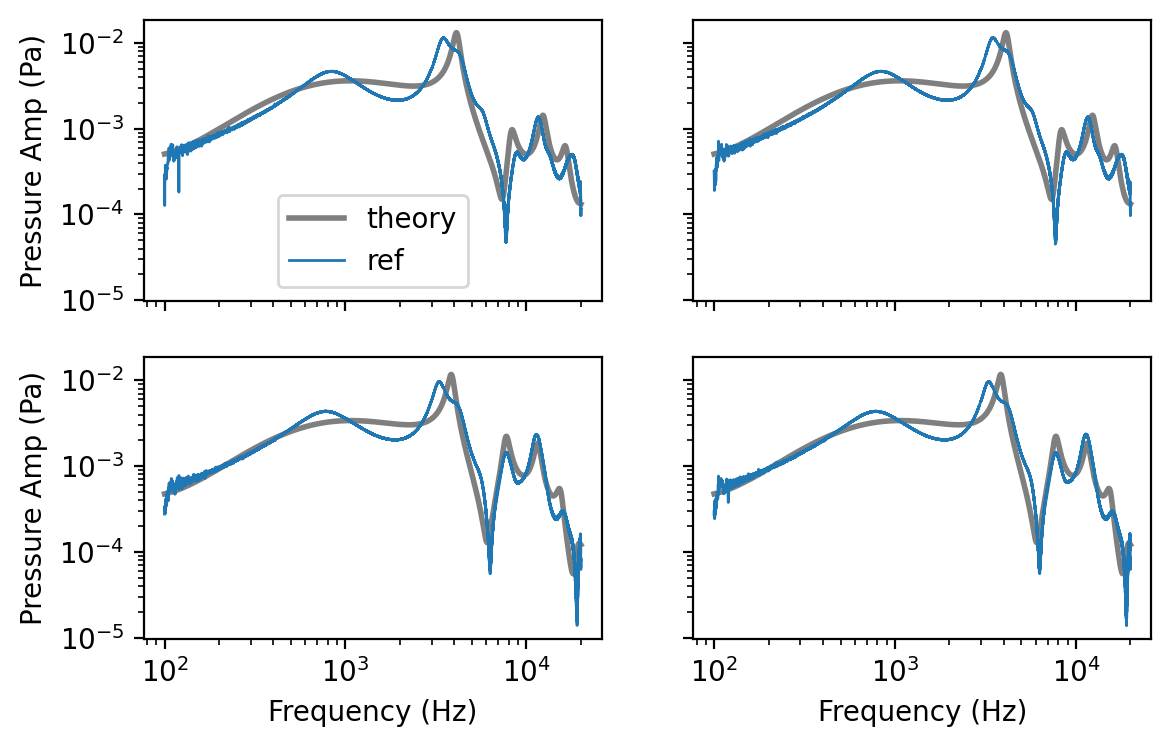

In [18]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, **figkwargs)
channel = 3
for i in range(2):
    for j in range(2):
        ii = i * 2 + j
        lw = 2
        speaker_cal = calibration_data["speaker_amplitude_f"](f_ref[i, j], calibration_data["speaker_amplitude"])
        axs[i,j].loglog(f_ref[i, j], np.abs(p_theory[i, j, :] * speaker_cal).T, 'k', label="theory", lw=lw, alpha=0.5)
        axs[i,j].loglog(f_ref[i, j], np.abs(p_ref[i, j, :]).T, 'C0', label="ref", lw=1, alpha=1)
        if i > 0 or j > 0:
            continue
        axs[i,j].legend()
axs[-1, 0].set_xlabel('Frequency (Hz)')
axs[-1, 1].set_xlabel('Frequency (Hz)')
axs[0, 0].set_ylabel(r'Pressure Amp (Pa)')
axs[-1, 0].set_ylabel(r'Pressure Amp (Pa)')
plt.show()

# 2. Amplitude Calibration

In [19]:
# Let's use the magnitude from the B&K probe, and solve for the speaker pressure, so that they match exactly
# we already did that in the previous step, that's speaker_p_correction, but we need to interpolate that
# onto f
speaker_p_correction_on_f = np.array(
    [[np.interp(f[i, j], f_ref[i, j], np.abs(speaker_p_correction[i, j])) for j in range(f_ref.shape[1])]
     for i in range(f_ref.shape[0])])
p_theory_mic = np.array([[[get_ptheory(
    f[i, j] * units.Hz,
    x_mic[k] + length_offset_cavern[i],
    cavern_model,
    L=length_tests[i] + length_offset_cavern[i],
    absorption_loss=alpha,
    # P0=calibration_data["speaker_amplitude_f"](f[i, j], calibration_data["speaker_amplitude"])
    P0=speaker_p_correction_on_f[i, j]
    )
    for k in range(p.shape[2])]
    for j in range(f_ref.shape[1])]
    for i in range(f_ref.shape[0])])

/tmp/ipykernel_13511/2292053185.py:7: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  p_theory_mic = np.array([[[get_ptheory(


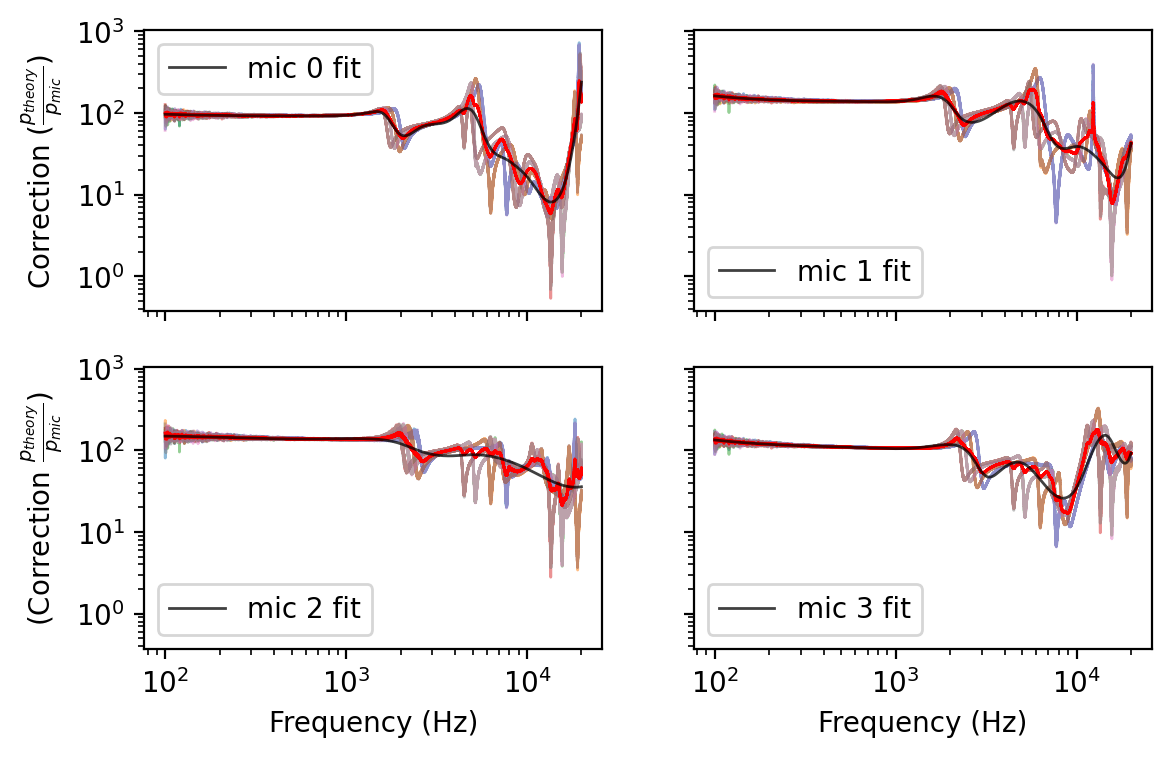

In [20]:
mic_p_correction = p_theory_mic / p[:p_ref.shape[0]]
N = p_ref.shape[0]
# polydata = [np.polyfit(np.log10(f[:N].ravel()), np.log10(np.abs(mic_p_correction[:, :, i]).ravel()), deg=7, w=1/f[:N].ravel())
#             for i in range(p.shape[2])]
# # polydata = [np.polyfit(np.log10(f[:N].ravel()), np.log10(np.abs(mic_p_correction[:, :, i]).ravel()), deg=9, w=1/np.log10(f[:N].ravel()))
# #             for i in range(p.shape[2])]
# # polydata = [np.polyfit(np.log10(f[:N].ravel()), np.log10(np.abs(mic_p_correction[:, :, i]).ravel()), deg=5)
# #             for i in range(p.shape[2])]
# calibration_data["mic_amplitude"] = polydata
# calibration_data["mic_amplitude_f"] = lambda f, p: np.stack([10**np.polyval(p[i], np.log10(f)) for i in range(len(p))], axis=0)

splinedata = [interpolate.splrep(
    np.log10(f[N, 0]), np.log10(np.abs(mic_p_correction[:, :, i].mean(axis=1).mean(axis=0))),
    w=1/f[N, 0],
    s=2/f.shape[-1]) for i in range(p.shape[2])]
calibration_data["mic_amplitude"] = splinedata
calibration_data["mic_amplitude_f"] = lambda f, p: np.stack([10**interpolate.splev(np.log10(f), p[i]) for i in range(len(p))], axis=0)


mic_cal = calibration_data["mic_amplitude_f"](f[0, 0], calibration_data["mic_amplitude"])
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, **figkwargs)
for i in range(2):
    for j in range(2):
        ii = i * 2 + j
        lw = 1
        axs[i,j].loglog(f[0, 0], np.abs(mic_p_correction[:, :, ii]).T.reshape(f[0, 0].size, -1), lw=lw, alpha=0.5)
        axs[i,j].loglog(f[0, 0], np.abs(mic_p_correction[:, :, ii]).mean(axis=1).mean(axis=0), 'r', lw=1, alpha=1)
        axs[i,j].loglog(f[0, 0], np.abs(mic_cal[ii]).T, 'k', label="mic %d fit" % ii, lw=lw, alpha=0.75)
        axs[i,j].legend()
axs[-1, 0].set_xlabel('Frequency (Hz)')
axs[-1, 1].set_xlabel('Frequency (Hz)')
axs[0, 0].set_ylabel(r'Correction ($\frac{p_{theory}}{p_{mic}}$)')
axs[-1, 0].set_ylabel(r'(Correction $\frac{p_{theory}}{p_{mic}}$)')
plt.show()

### Debug Plots

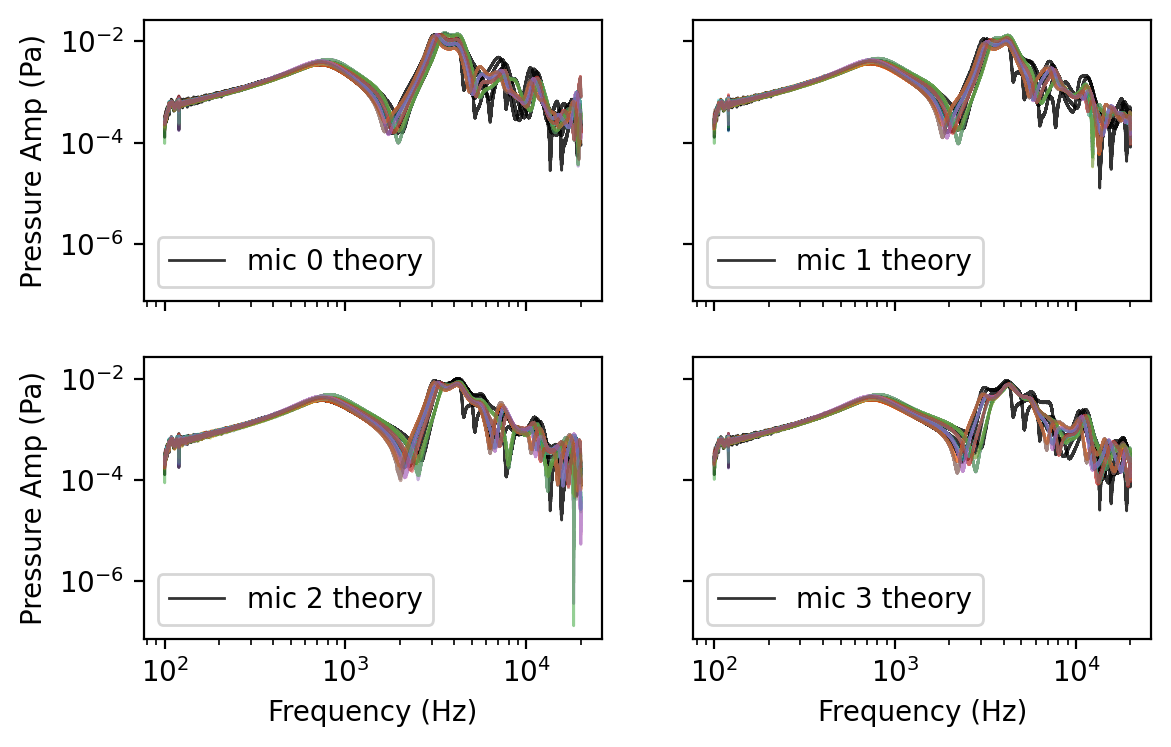

In [21]:
mic_cal = calibration_data["mic_amplitude_f"](f[0, 0], calibration_data["mic_amplitude"])
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, **figkwargs)
for i in range(2):
    for j in range(2):
        ii = i * 2 + j
        lw = 1
        axs[i,j].loglog(f[0, 0], np.abs(p_theory_mic[:, 0, ii]).T, 'k', lw=lw, alpha=0.8)
        axs[i,j].loglog(f[0, 0], np.abs(p[:, :, ii] * mic_cal[ii]).T.reshape(f[0, 0].size, -1), lw=lw, alpha=0.5)
        axs[i,j].legend(["mic %d theory" % ii])
axs[-1, 0].set_xlabel('Frequency (Hz)')
axs[-1, 1].set_xlabel('Frequency (Hz)')
axs[0, 0].set_ylabel(r'Pressure Amp (Pa)')
axs[-1, 0].set_ylabel(r'Pressure Amp (Pa)')
plt.show()

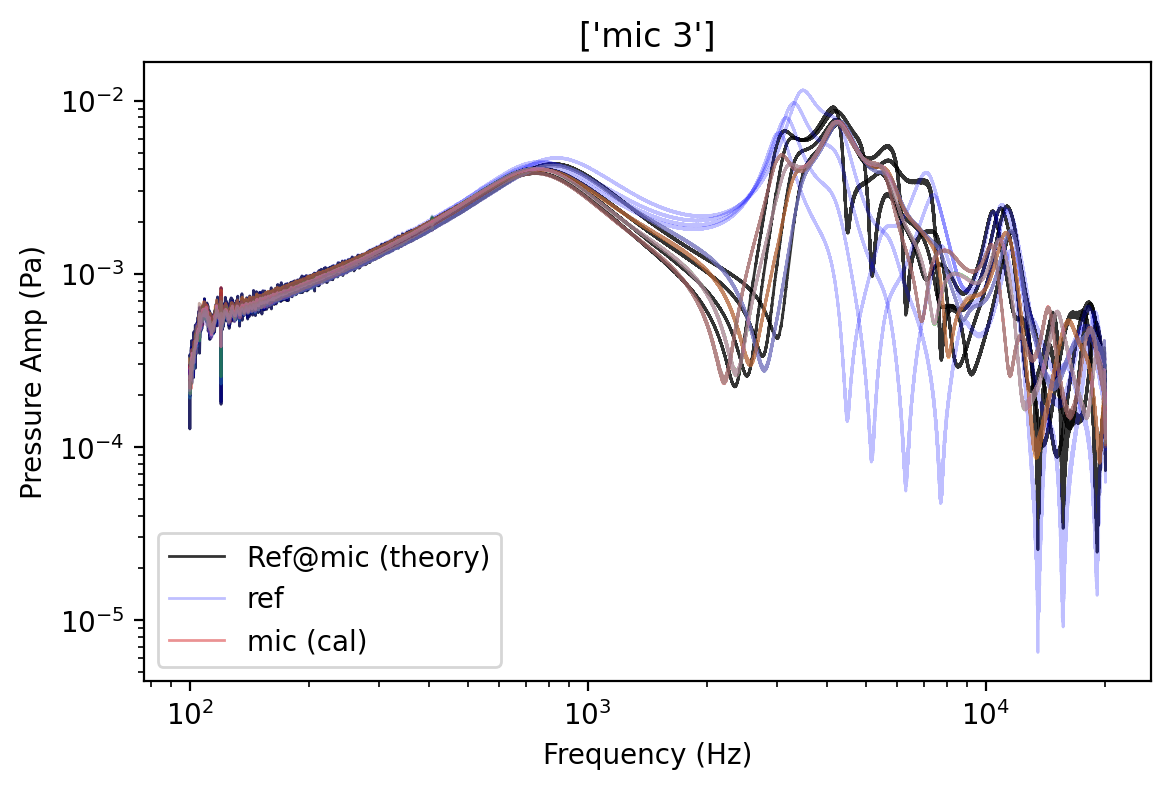

In [22]:
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, **figkwargs)
i = 1; j=1
ii = i * 2 + j
lw = 1
axs.loglog(f[0, 0], np.abs(p_theory_mic[:N, 0, ii]).T, 'k', lw=lw, alpha=0.8)
axs.loglog(f_ref[0, 0], np.abs(p_ref[:, 0]).T, 'b', lw=lw, alpha=0.25)
axs.loglog(f[0, 0], np.abs(p[:N, :, ii] * mic_cal[ii]).T.reshape(f[0, 0].size, -1), lw=lw, alpha=0.5)
axs.set_title(["mic %d" % ii])
axs.set_xlabel('Frequency (Hz)')
axs.set_ylabel(r'Pressure Amp (Pa)')
custom_lines = [plt.Line2D([0], [0], color='k', lw=1, alpha=0.8),
                plt.Line2D([0], [0], color='b', lw=1, alpha=0.25),
                plt.Line2D([0], [0], color='C3', lw=1, alpha=0.5)]
axs.legend(custom_lines, ['Ref@mic (theory)', 'ref', 'mic (cal)'])
plt.show()

/home/mpu/.pyenv/versions/3.11.2/envs/auren/lib/python3.11/site-packages/matplotlib/cbook.py:1345: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


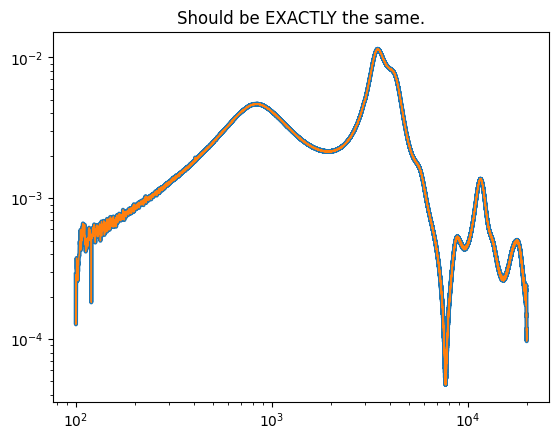

In [23]:
i=0; j=0
p_theory_check = get_ptheory(
    f[i, j] * units.Hz,
    x_probe[i] + length_offset_cavern[i],
    cavern_model,
    L=length_tests[i] + length_offset_cavern[i],
    absorption_loss=alpha,
    P0=speaker_p_correction_on_f[i, j]
    )
plt.title("Should be EXACTLY the same.")
plt.loglog(f_ref[i, j], np.abs(p_ref[i, j]), lw=3)
plt.loglog(f[i, j], np.abs(p_theory_check), lw=1)
plt.show()

# 3. Phase Calibration

In [24]:
# For this set, we have the reference channel phase be 0
ref_channel = 3
N = p_ref.shape[0]
p_theory_ref_channel = np.array([[get_ptheory(
    f[i + N, j] * units.Hz,
    x_mic[ref_channel] + length_offset_cavern[i],
    cavern_model,
    L=length_tests[i] + length_offset_cavern[i],
    absorption_loss=alpha,
    P0=1
    ) for j in range(p_ref.shape[1])] for i in range(p_ref.shape[0])])
p_phase = p[N:, :, ref_channel] / p_theory_ref_channel

p_theory_mic_phase = np.array([[[get_ptheory(
    f[i, j] * units.Hz,
    x_mic[k] + length_offset_cavern[i],
    cavern_model,
    L=length_tests[i] + length_offset_cavern[i],
    absorption_loss=alpha,
    P0=p_phase[i, j]
    )
    for k in range(p.shape[2])]
    for j in range(f_ref.shape[1])]
    for i in range(f_ref.shape[0])])
i = 1; j = 1
# plt.semilogx(f[i, j], np.angle(p[i + N, j, ref_channel]) - np.angle(p_theory_mic_phase[i, j, ref_channel]))
# plt.show()

# plt.semilogx(f[0, 0], np.angle(p[0, 0, 2]) - np.angle(p_theory_mic_phase[i, j, 2]))
# plt.ylim(-np.pi, np.pi)
# plt.show()

# speaker_p_correction_phase = p[N:] / p_theory_mic_phase
# plt.semilogx(f[0, 0], np.angle(speaker_p_correction_phase[i, j, 2]))
# plt.ylim(-np.pi, np.pi)
# plt.show()

/tmp/ipykernel_13511/2009399687.py:4: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  p_theory_ref_channel = np.array([[get_ptheory(
/tmp/ipykernel_13511/2009399687.py:14: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  p_theory_mic_phase = np.array([[[get_ptheory(


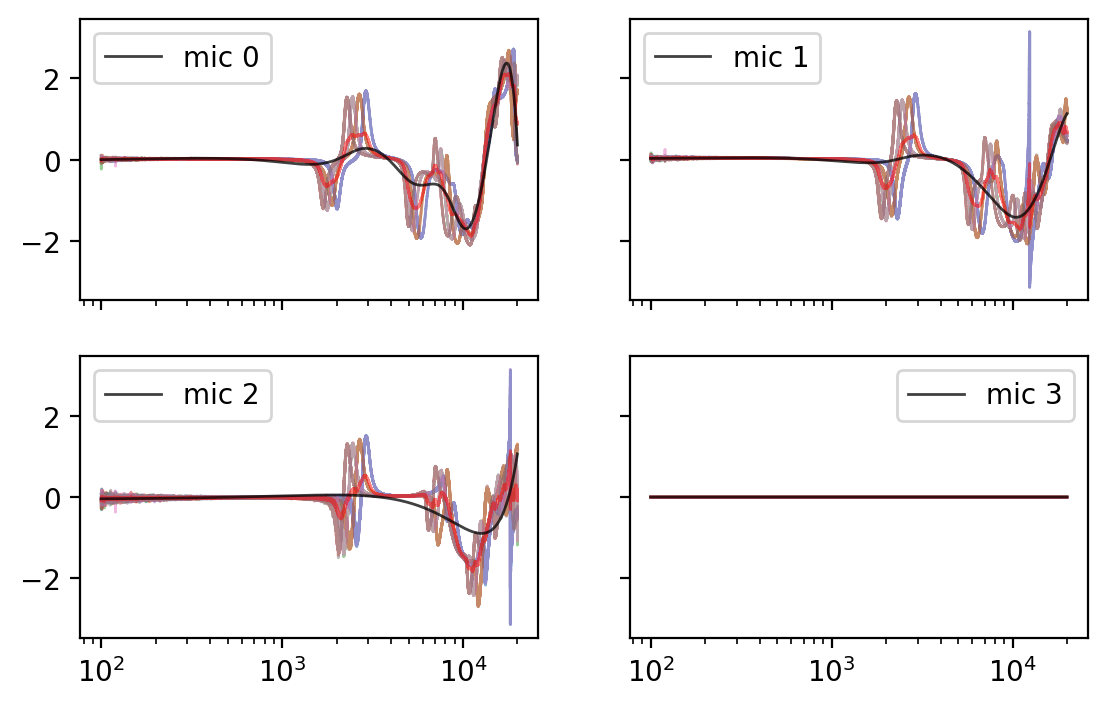

In [25]:
N = p_ref.shape[0]
mic_p_correction_phase = (p_theory_mic_phase / p[N:])
mic_p_correction_phase = mic_p_correction_phase / np.abs(mic_p_correction_phase)
# # polydata = [np.polyfit(np.log10(f[:N].ravel()), np.angle(mic_p_correction_phase[:, :, i]).ravel(), deg=4, w=1/f[:N].ravel())
# #             for i in range(p.shape[2])]
# # calibration_data["mic_phase_f"] = lambda f, p: np.stack([np.polyval(p[i], np.log10(f)) for i in range(len(p))], axis=0)
# polydata = [np.polyfit((f[:N].ravel()), np.angle(mic_p_correction_phase[:, :, i]).ravel(), deg=6, w=1/f[:N].ravel())
#             for i in range(p.shape[2])]
# calibration_data["mic_phase_f"] = lambda f, p: np.stack([np.polyval(p[i], (f)) for i in range(len(p))], axis=0)
# calibration_data["mic_phase"] = polydata
splinedata_phase = [interpolate.splrep(
    (f[N, 0]), np.angle(mic_p_correction_phase[:, :, i].mean(axis=1).mean(axis=0)),
    w=1/f[N, 0],
    s=32/f.shape[-1]) for i in range(p.shape[2])]
calibration_data["mic_phase"] = splinedata_phase
calibration_data["mic_phase_f"] = lambda f, p: np.stack([interpolate.splev((f), p[i]) for i in range(len(p))], axis=0)


mic_cal_phase = calibration_data["mic_phase_f"](f[0, 0], calibration_data["mic_phase"])
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, **figkwargs)
for i in range(2):
    for j in range(2):
        ii = i * 2 + j
        lw = 1
        axs[i,j].semilogx(f[0, 0], np.angle(mic_p_correction_phase[:, :, ii]).T.reshape(f[0, 0].size, -1), lw=lw, alpha=0.5)
        axs[i,j].semilogx(f[0, 0], np.angle(mic_p_correction_phase[:, :, ii]).mean(axis=1).mean(axis=0), 'r-', lw=1, alpha=0.5)
        axs[i,j].semilogx(f[0, 0], mic_cal_phase[ii].T, 'k', label="mic %d" % ii, lw=lw, alpha=0.75)

        axs[i,j].legend()
plt.show()

In [26]:
# TODO, Check the calibration (how to apply it to the pressure, do plots similar to the amplitude)


# Verification
Based on two pressure measurements, can we guess what the B&K probe did?

In [27]:
mic_cals_amp = calibration_data["mic_amplitude_f"](f[0, 0], calibration_data["mic_amplitude"])
mic_cals = mic_cals_amp * np.exp(1j * calibration_data["mic_phase_f"](f[0, 0], calibration_data["mic_phase"]))
# mic_cals = calibration_data["mic_amplitude_f"](f[0, 0], calibration_data["mic_amplitude"])

In [28]:
p_cal = p[:p_ref.shape[0], :] * mic_cals
p_cal_amp = p[:p_ref.shape[0], :] * mic_cals_amp
p_ref_predict = np.zeros_like(p_ref)
p_ref_predict0 = np.zeros_like(p_ref)
p_ref_predict_amp = np.zeros_like(p_ref)
cavern_model.absorption_loss = 0.04
print(cavern_model.absorption_loss)
for i in range(4):
    # using mic 1 and 3
    cavern_model.L = length_tests[i] + length_offset_cavern[i]
    prp = cavern_model.p_measured(
        f[i] * units.Hz, x_probe[i] + length_offset_cavern[i],
        x_mic[1] + length_offset_cavern[i], x_mic[3] + length_offset_cavern[i],
        p_cal[i, :, 1], p_cal[i, :, 3])
    p_ref_predict[i] = prp.magnitude

    # using mic 2 and 3
    prp = cavern_model.p_measured(
        f[i] * units.Hz, x_probe[i] + length_offset_cavern[i],
        x_mic[2] + length_offset_cavern[i], x_mic[3] + length_offset_cavern[i],
        p_cal[i, :, 2], p_cal[i, :, 3])
    p_ref_predict0[i] = prp.magnitude

    # Using mic 1 and 3, amplitude only
    prp = cavern_model.p_measured(
        f[i] * units.Hz, x_probe[i] + length_offset_cavern[i],
        x_mic[1] + length_offset_cavern[i], x_mic[3] + length_offset_cavern[i],
        p_cal_amp[i, :, 1], p_cal_amp[i, :, 3])
    p_ref_predict_amp[i] = prp.magnitude


0.04


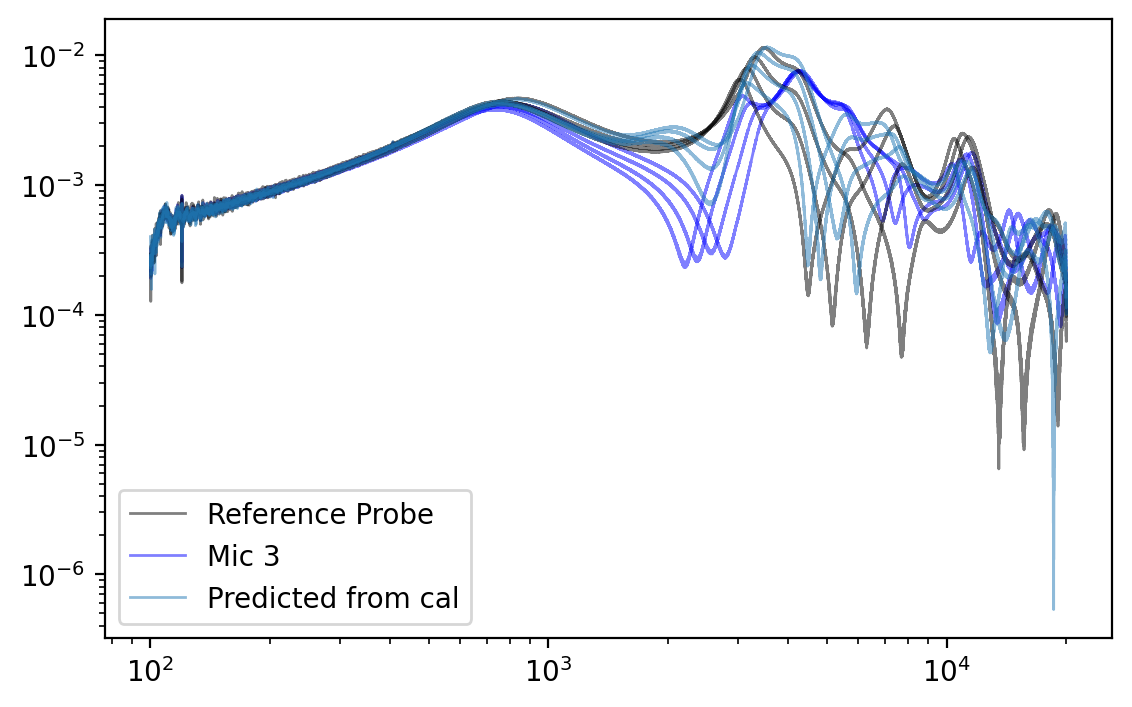

In [29]:
fig, axs = plt.subplots(1, 1, sharex=True, **figkwargs)
axs.loglog(f[0, 0], np.abs(p_cal[:, 0, 3]).T, 'b', lw=1, alpha=0.5)
axs.loglog(f[0, 0], np.abs(p_ref[:, 0]).T, 'k', lw=1, alpha=0.5)
axs.loglog(f[0, 0], np.abs(p_ref_predict[:, 0]).T, 'C0', lw=1, alpha=0.5)
# axs[1].semilogx(f_ref[0, 0], np.angle(p_ref[:, 0]).T, 'k', lw=1, alpha=0.5)
# axs[1].semilogx(f[0, 0], np.angle(p_ref_predict[:, 0]).T, 'b', lw=2, alpha=0.75)
custom_lines = [
    plt.Line2D([0], [0], color='k', lw=1,alpha=0.5),
    plt.Line2D([0], [0], color='b', lw=1, alpha=0.5),
    plt.Line2D([0], [0], color='C0', lw=1, alpha=0.5),
                            ]
axs.legend(custom_lines, ['Reference Probe', 'Mic 3', 'Predicted from cal'])
plt.show()

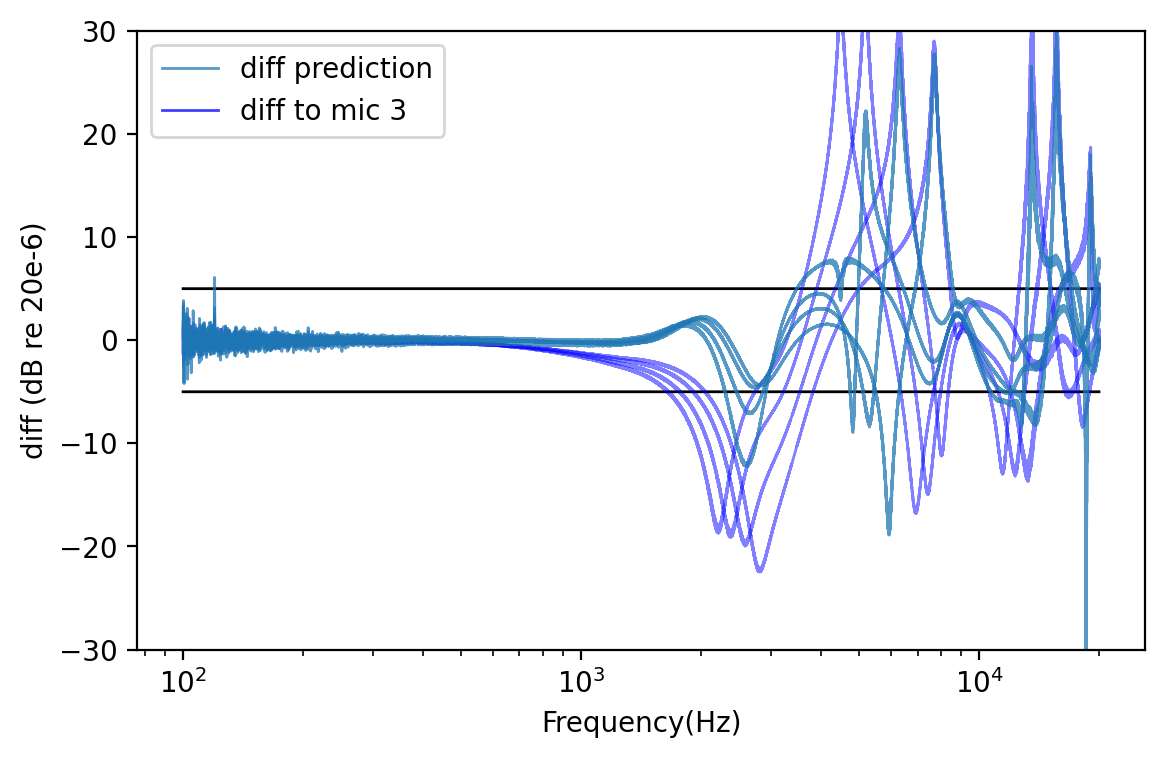

In [48]:
# fig, axs = plt.subplots(2, 1, sharex=True, **figkwargs)
# axs[0].loglog(f_ref[0, 0], np.abs(p_ref[:, 0]).T, 'k', lw=1, alpha=0.5)
# axs[0].loglog(f[0, 0], np.abs(p_ref_predict[:, 0]).T, 'C0', lw=1, alpha=0.75)
# custom_lines = [
#     plt.Line2D([0], [0], color='k', lw=1, alpha=0.5),
#     plt.Line2D([0], [0], color='b', lw=1, alpha=0.75)]
# axs[0].legend(custom_lines, ['Reference Probe',  'Predicted from Cal'])

fig, axs = plt.subplots(1, 1, sharex=True, **figkwargs)
axs.semilogx(f[0, 0], f[0, 0]*0 + 5, 'k', lw=1, alpha=1)
axs.semilogx(f[0, 0], f[0, 0]*0 - 5, 'k', lw=1, alpha=1)
axs.semilogx(f[0, 0], todB(p_cal[:, 0, 3]).T - todB(p_ref[:, 0]).T, 'b', lw=1, alpha=0.5)
axs.semilogx(f[0, 0], todB(p_ref_predict[:, 0]).T - todB(p_ref[:, 0]).T, 'C0', lw=1, alpha=0.75)
# axs.semilogx(f[0, 0], todB(p_ref_predict_amp[:, 0]).T - todB(p_ref[:, 0]).T, 'C1', lw=1, alpha=0.5)
# axs.semilogx(f[0, 0], todB(p_ref_predict0[:, 0]).T - todB(p_ref[:, 0]).T, 'C2', lw=1, alpha=0.5)
# axs.semilogx(f[0, 0], todB((p_ref_predict0[:, 0] + p_ref_predict[:, 0]) * 0.5).T - todB(p_ref[:, 0]).T, 'C3', lw=1, alpha=0.5)
custom_lines = [
    plt.Line2D([0], [0], color='C0', lw=1, alpha=0.75),
    # plt.Line2D([0], [0], color='C1', lw=1, alpha=0.5),
    # plt.Line2D([0], [0], color='C2', lw=1, alpha=0.5),
    plt.Line2D([0], [0], color='b', lw=1, alpha=0.75)
]
axs.legend(custom_lines, ['diff prediction', 'diff to mic 3',])
# axs.legend(custom_lines, ['diff to prediction', 'diff amp-only cal', 'diff to mic 3',])
axs.set_ylabel('diff (dB re 20e-6)')
axs.set_xlabel('Frequency(Hz)')
# axs[1].semilogx(f_ref[0, 0], np.angle(p_ref[:, 0] / p_ref_predict[:, 0]).T, 'k', lw=1, alpha=0.5)
# axs[1].semilogx(f[0, 0], np.angle().T, 'b', lw=2, alpha=0.75)
axs.set_ylim([-30, 30])
plt.show()

In [31]:
f_ref.shape

(4, 2, 99500)

# Alternative Calibration Method

In [32]:
p_ref_on_f = np.array([[np.interp(f[i, j], f_ref[i, j], p_ref[i, j]) for j in range(p_ref.shape[1])] for i in range(p_ref.shape[0])])

In [33]:

cavern_model.absorption_loss = 0.4

In [34]:
channels = [0, 1, 2, 3]
n_channels = len(channels)
n_caverns = 4
x = x_mic[channels].to('m').magnitude
# x[2] -= 0.002 # See what an offset does
# x[0] += 0.002 # See what an offset does

k = cavern_model.k(f[0, 0]).magnitude
A = np.zeros((p.shape[-1], n_channels * n_caverns, 2 * n_caverns + n_channels-1), dtype=np.complex128)
b = np.zeros((p.shape[-1], n_channels * n_caverns), dtype=np.complex128)
for j in range(n_caverns):
    A[:, j*n_channels:(j+1) * n_channels, j*2 + 0] = np.exp(-1j * k[:, None] * x[None, :])
    A[:, j*n_channels:(j+1) * n_channels, j*2 + 1] = np.exp( 1j * k[:, None] * x[None, :])
    for i in range(n_channels - 1):
        A[:, j*n_channels + i, -n_channels + 1 + i] = -p[j, 0, channels[i]]
        # A[:, j*n_channels + 1, -1] = -p[j, 0, channels[1]]
    b[:, j*n_channels + n_channels - 1] = p[j, 0, channels[-1]]

Ainv = np.linalg.pinv(A)
cal = np.einsum('ijk,ik->ij', Ainv, b)


In [35]:
# plt.matshow(np.real(A[0]))

In [36]:
cal_phase = [interpolate.splrep(
    (f[0, 0]), np.angle(cal[:, i]),w=np.sqrt(f[0, 0] / f[0, 0].max()),
    s=0.02*f.shape[-1]) for i in range( -n_channels + 1, 0)]
cal_amp = [interpolate.splrep(
    np.log10(f[0, 0]), np.log10(np.abs(cal[:, i])), #w=1/f[0, 0],
    s=0.01*f.shape[-1]) for i in range( -n_channels + 1, 0)]
cal_phase = np.stack([interpolate.splev((f[0, 0]), cal_phase[i]) for i in range(n_channels-1)], axis=0)
cal_amp = np.stack([10**interpolate.splev(np.log10(f[0, 0]), cal_amp[i]) for i in range(n_channels-1)], axis=0)
cal2 = (cal_amp * np.exp(1j*cal_phase)).T

(-180.0, 180.0)

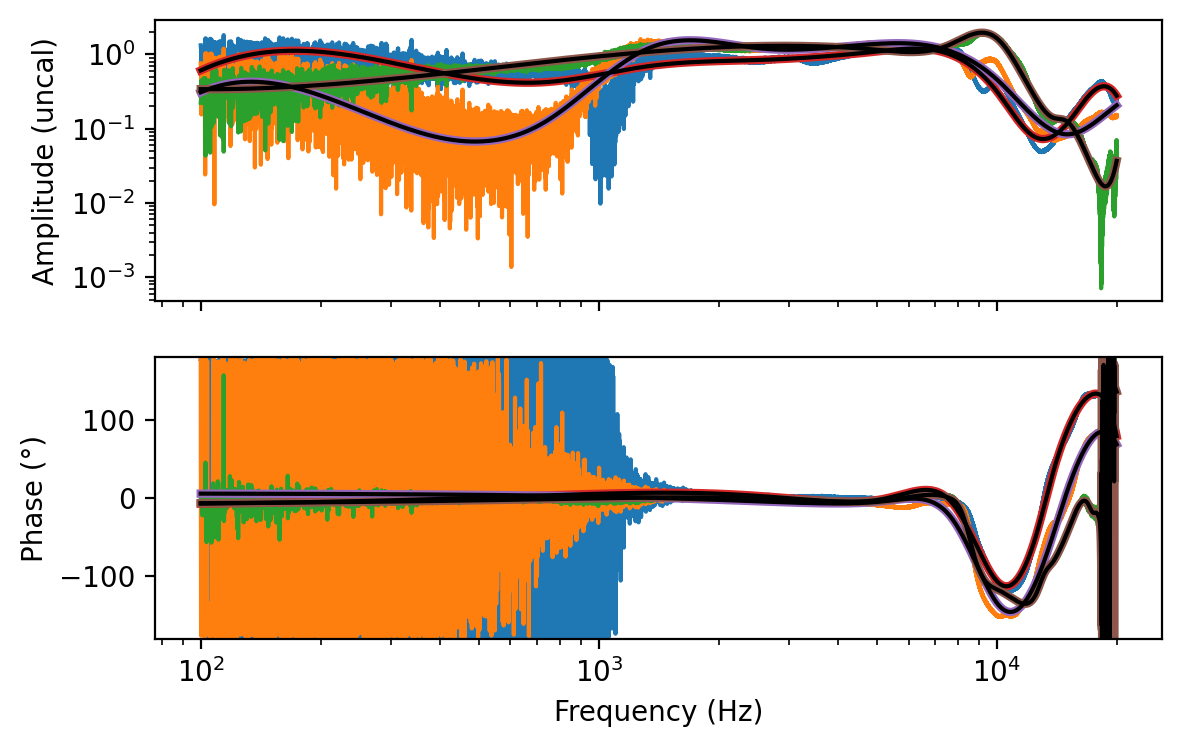

In [37]:
fig, axs = plt.subplots(2, 1, sharex=True, **figkwargs)
axs[0].loglog(f[0, 0], np.abs(cal[:, -n_channels + 1:]))
axs[0].loglog(f[0, 0], np.abs(cal2[:, -n_channels + 1:]), lw=3)
axs[0].loglog(f[0, 0], cal_amp.T, 'k')
axs[0].set_ylabel("Amplitude (uncal)")
axs[1].semilogx(f[0, 0], np.rad2deg(np.angle(cal[:, -n_channels + 1:])))
axs[1].semilogx(f[0, 0], np.rad2deg(np.angle(cal2[:, -n_channels + 1:])), lw=3)
axs[1].semilogx(f[0, 0], np.rad2deg(cal_phase.T),'k')
axs[1].set_ylabel('Phase (°)')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylim([-180, 180])

In [38]:
# cal = cal2

Text(0.5, 0, 'Frequency (Hz)')

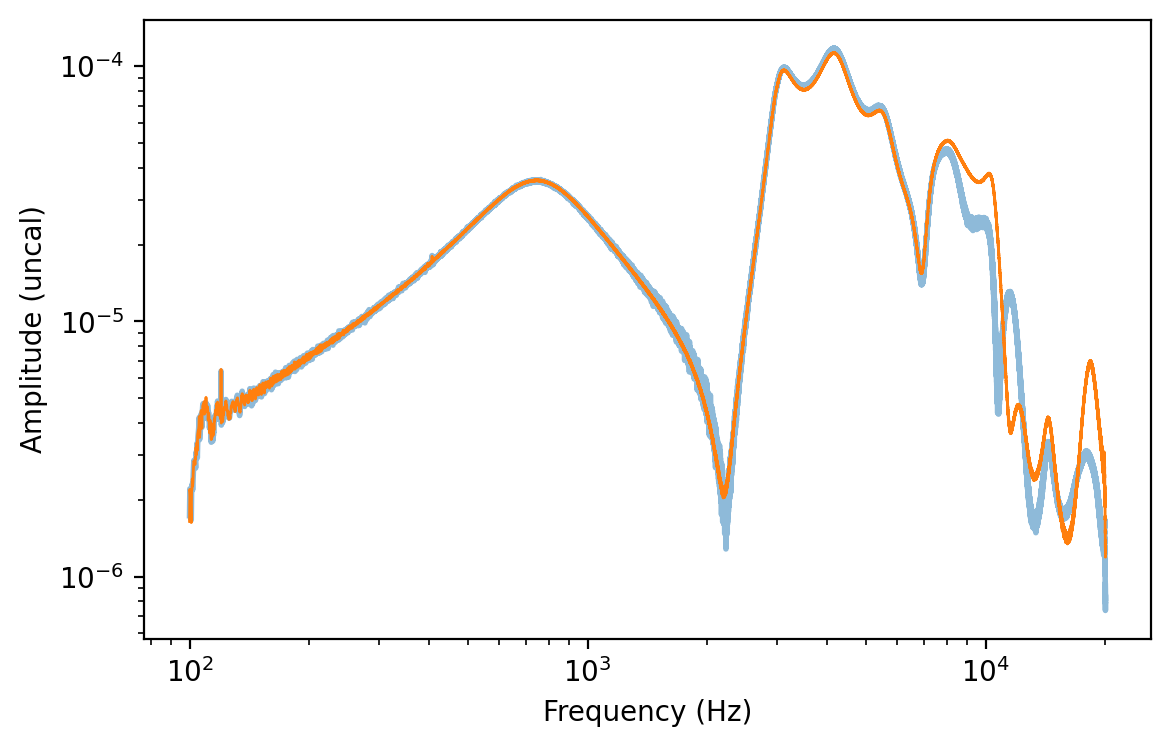

In [39]:
p3_pred = cavern_model.p_measured(
    f[0, 0] * units.Hz,
    x[-1] * units.m,
    x[-3] * units.m, x[-2] * units.m,
    p[3, 0, channels[-3]] * cal[:, -2], p[3, 0, channels[-2]] * cal[:, -1])

fig, axs = plt.subplots(1, 1, sharex=True, **figkwargs)
axs.loglog(f[0, 0], np.abs(p3_pred), 'C0', lw=2, alpha=0.5, label="Prediction")
axs.loglog(f[0, 0], np.abs(p[3, 0, 3]), 'C1', lw=1, label="Measured")
axs.set_ylabel("Amplitude (uncal)")
axs.set_xlabel('Frequency (Hz)')

In [40]:
# Now, calibrate the amplitude using a VERY similar approach to older attempts, but using the B&K probe measured pressure
x_probe_offset = 0* units.mm
# NOTE :We can get more examples of amp_cal by using a different mic with the final mic (3 rounds in total)
p_probe_pred = cavern_model.p_measured(
    f[0, 0] * units.Hz, x_probe[0] + x_probe_offset,
    x[-2] * units.m, x[-1] * units.m,
    p[3, 0, channels[-2]] * cal[:, -1], p[3, 0, channels[-1]])
mic_p_correction = p_ref_on_f[:, 0] / p_probe_pred

amp_cal = np.abs(mic_p_correction)
amp_cal_orig = np.abs(mic_p_correction)
amp_cal_spline = interpolate.splrep(
    np.log10(f[0, 0]), np.log10(np.abs(amp_cal.mean(0))), w=1/(f[0, 0] / f.max()),
    s=0.5*f.shape[-1])
amp_cal2 = 10**interpolate.splev(np.log10(f[0, 0]), amp_cal_spline)


/home/mpu/.pyenv/versions/3.11.2/envs/auren/lib/python3.11/site-packages/scipy/interpolate/_fitpack_impl.py:276: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  n, c, fp, ier = dfitpack.curfit(task, x, y, w, t, wrk, iwrk,


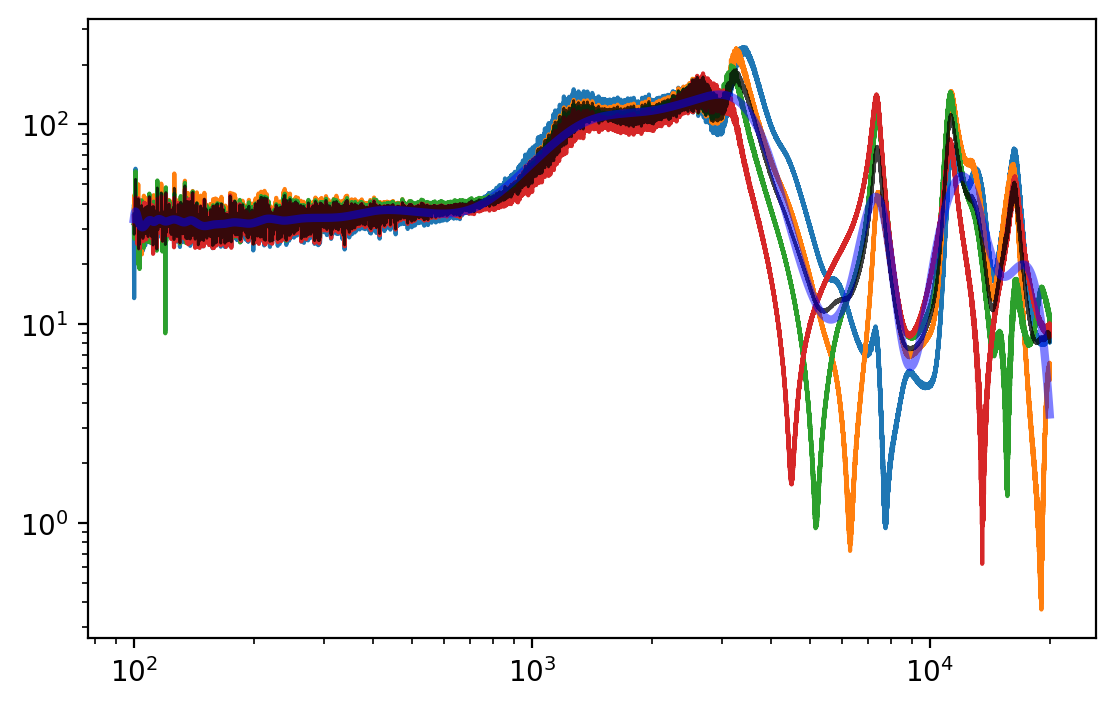

In [41]:
plt.figure(**figkwargs)
plt.loglog(f[0, 0], amp_cal.T)
plt.loglog(f[0, 0], amp_cal.mean(0), 'k', alpha=0.75, lw=1)
plt.loglog(f[0, 0], amp_cal2, 'b', alpha=0.5, lw=3)

In [42]:
amp_cal = amp_cal2
# amp_cal = amp_cal_orig.mean(0)

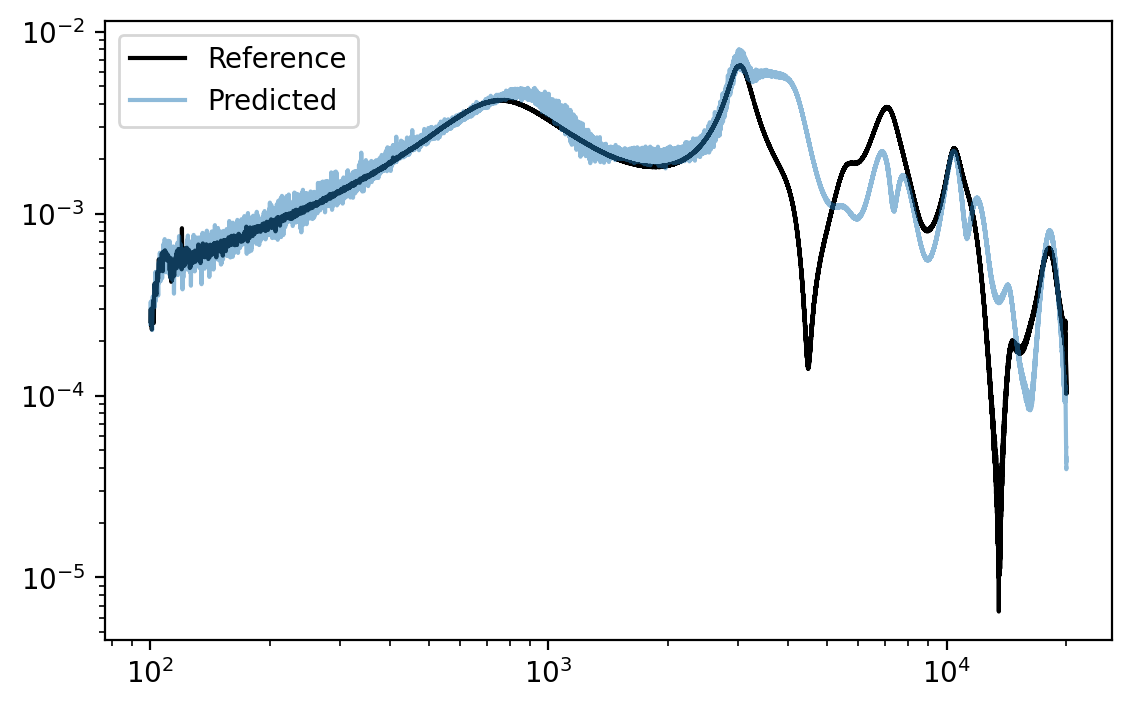

In [43]:
N = p_ref.shape[0]
p_probe_pred2 = cavern_model.p_measured(
    f[0, 0] * units.Hz, x_probe[0] + x_probe_offset,
    x[-2] * units.m, x[-1] * units.m,
    p[:N, 0, channels[-2]] * cal[:, -1] * amp_cal, p[:N, 0, channels[-1]] * amp_cal)

plt.figure(**figkwargs)
plt.loglog(f_ref[0, 0], np.abs(p_ref[3, 0]), 'k', label='Reference')
plt.loglog(f_ref[0, 0], np.abs(p_probe_pred2[3]), 'C0', alpha=0.5, label="Predicted")
plt.legend()

/home/mpu/.pyenv/versions/3.11.2/envs/auren/lib/python3.11/site-packages/matplotlib/cbook.py:1345: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


(-30.0, 30.0)

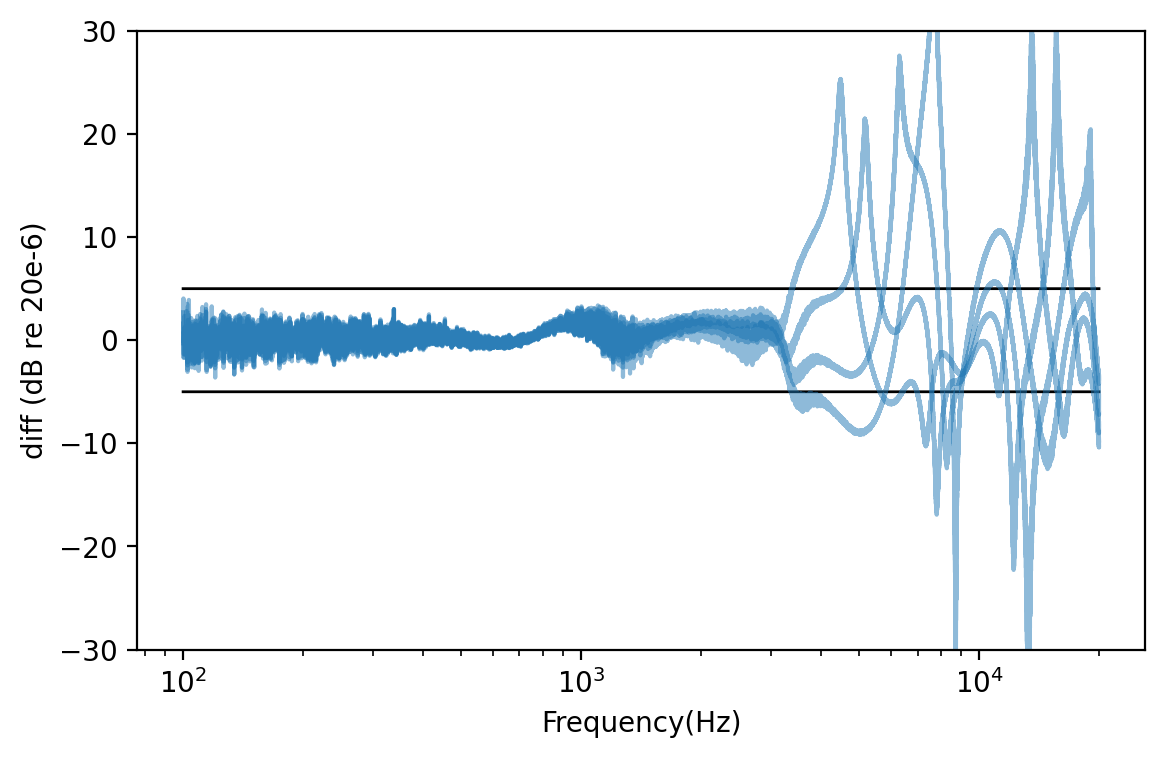

In [50]:
plt.figure(**figkwargs)
plt.semilogx(f[0, 0], f[0, 0]*0 + 5, 'k', lw=1, alpha=1)
plt.semilogx(f[0, 0], f[0, 0]*0 - 5, 'k', lw=1, alpha=1)
plt.semilogx(f_ref[0, 0], todB(p_probe_pred2).T - todB(p_ref[:, 0].T), 'C0', alpha=0.5)
plt.ylabel('diff (dB re 20e-6)')
plt.xlabel('Frequency(Hz)')
plt.ylim([-30, 30])

### Old, optimization approach
didn't work as well as direct solution, also much, much slower

In [45]:
set_matplotlib_close
def cost(x, fc, pc, p_ref_at_fc, cavern_model, x1, x2, x3, xp):
    a1, a2, a3, th1, th2 = x
    p_pred = cavern_model.p_measured(fc, xp, x1, x3, pc[:, 1] * a1 * np.exp(1j * th1), np.abs(pc[:, 3]) * a3)
    p32 = cavern_model.p_measured(fc, x3, x1, x2, pc[:, 1] * a1 * np.exp(1j * th1), pc[:, 2] * a2 * np.exp(1j * th2))
    cost0 = np.sum(np.abs(np.log10(np.abs(p_pred)) - np.log10(np.abs(p_ref_at_fc))))
    cost1 = np.sum(np.abs(np.log10(np.abs(pc[:, 3] * a3)) - np.log10(np.abs(p32))))
    cost2 = np.sum(np.abs(np.angle((pc[:, 3] * a3) / p32.magnitude)))
    return cost0 + cost1 + cost2

i = 85000
N = p_ref.shape[0]
mag_initial = np.abs(p_ref).mean() / np.abs(p).mean()
mag_max = (np.abs(p_ref) / np.abs(p[:N, :, 3])).max() * 2
mag_min = (np.abs(p_ref) / np.abs(p[:N, :, 3])).min() / 2
res = optimize.minimize(
    cost, [mag_initial, mag_initial, mag_initial, 0, 0], args=(
        f[:N, 0, i] * units.Hz, p[:N, 0, :, i], p_ref[:, 0, i],
        cavern_model, x_mic[1], x_mic[2], x_mic[3], x_probe[0]
    ),
    bounds=(
        (mag_min, mag_max),
        (mag_min, mag_max),
        (mag_min, mag_max),
        (-np.pi, np.pi),
        (-np.pi, np.pi),
    ),
    method='Nelder-Mead' # 2 seconds, succes, f = 0.8
    # method='SLSQP' # 2.1 seconds, success, f = 0.84
    # method='Powell' # 2.5s, success, f=1.36572
    # method='trust-constr', # 9.1s, succes, f=1.3757
    # method='COBYLA' # 0.2 seconds, success, f = 2.1673
    # method='L-BFGS-B' # 1.3 seconds, success, f = 2.33
    # method='TNC' # 1.8s, no success
)
res

NameError: name 'set_matplotlib_close' is not defined

In [ ]:

def cost(x, fc, pc, cavern_model, x1, x2, x3):
    th1, th2 = x
    p32 = cavern_model.p_measured(fc, x3, x1, x2, pc[:, 1] * np.exp(1j * th1), pc[:, 2] * np.exp(1j * th2))
    cost2 = np.sum(np.abs(np.angle((pc[:, 3]) / p32.magnitude)))
    return cost2

i = 85000
N = p_ref.shape[0]
mag_initial = np.abs(p_ref).mean() / np.abs(p).mean()
mag_max = (np.abs(p_ref) / np.abs(p[:N, :, 3])).max() * 2
mag_min = (np.abs(p_ref) / np.abs(p[:N, :, 3])).min() / 2
res = optimize.minimize(
    cost, [0, 0], args=(
        f[:N, 0, i] * units.Hz, p[:N, 0, :, i],
        cavern_model, x_mic[1], x_mic[2], x_mic[3]
    ),
    bounds=(
        (-np.pi, np.pi),
        (-np.pi, np.pi),
    ),
    method='Nelder-Mead'
)
initial_mag, res


(48.63143241830213,
        message: Optimization terminated successfully.
        success: True
         status: 0
            fun: 0.4757968571901724
              x: [ 1.081e+00  1.080e+00]
            nit: 93
           nfev: 179
  final_simplex: (array([[ 1.081e+00,  1.080e+00],
                        [ 1.081e+00,  1.080e+00],
                        [ 1.081e+00,  1.080e+00]]), array([ 4.758e-01,  4.758e-01,  4.758e-01])))

## Debug Plots